In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# ResNet18, Batch size = 512, Epochs = 100

## **1. Data Preprocessing and Augmentation**
- **Normalization and Resizing**:
  - Images are resized to `224x224` using Lanczos resampling and normalized with a mean of `0.5` and standard deviation of `0.5`.
- **Data Augmentation**:
  - Augmentation pipeline includes:
    - `RandomResizedCrop`: Crops images to random sizes and aspect ratios.
    - `RandomHorizontalFlip`: Randomly flips the image horizontally.
    - `ColorJitter`: Randomly changes brightness, contrast, saturation, and hue.
    - `GaussianBlur`: Blurs the image with a random kernel size and sigma.
  - These augmentations help generate two different views of the same image, which is crucial for contrastive learning.

In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from PIL import Image
import matplotlib.pyplot as plt

train_images_path = "/content/drive/MyDrive/Brain_images/brain_train_image_final.npy"
train_labels_path = "/content/drive/MyDrive/Brain_images/brain_train_label.npy"
test_images_path = "/content/drive/MyDrive/Brain_images/brain_test_image_final.npy"
test_labels_path = "/content/drive/MyDrive/Brain_images/brain_test_label.npy"

# Load the data
final_X_train_modified = np.load(train_images_path)[:, 1, :, :]
final_X_test_modified = np.load(test_images_path)[:, 1, :, :]
train_labels = np.load(train_labels_path)
test_labels = np.load(test_labels_path)

# Normalize and Resize Images using Pillow
def normalize_and_resize(images, target_size=(224, 224)):
    resized_images = []
    for img in images:
        img = Image.fromarray((img * 255).astype(np.uint8))
        img_resized = img.resize(target_size, Image.Resampling.LANCZOS)
        resized_images.append(np.array(img_resized) / 255.0)
    return np.array(resized_images)

final_X_train_resized = normalize_and_resize(final_X_train_modified)
final_X_test_resized = normalize_and_resize(final_X_test_modified)

# Define SimCLR Augmentation Transform
transform_simclr = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(size=224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

## **2. Custom Dataset and Visualize Augmented Views**
- **SimCLRDataset**:
  - Generates two augmented views of each input image to be used as positive pairs for contrastive learning.
  - Plot two augmented views of the same input image.

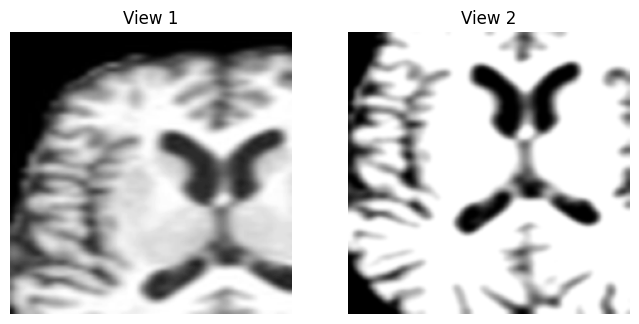

In [5]:
# Custom Dataset for SimCLR
class SimCLRDataset(Dataset):
    def __init__(self, images, transform):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        img_1 = self.transform(img)
        img_2 = self.transform(img)
        return img_1, img_2

train_dataset = SimCLRDataset(final_X_train_resized, transform_simclr)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

# Visualize Augmented Views
def plot_augmented_views(dataset, index=0):
    img1, img2 = dataset[index]
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    for i, (img, title) in enumerate(zip([img1, img2], ["View 1", "View 2"])):
        axes[i].imshow(img.permute(1, 2, 0).numpy().squeeze(), cmap='gray')
        axes[i].set_title(title)
        axes[i].axis("off")
    plt.show()

plot_augmented_views(train_dataset)

## **3. SimCLR Model Architecture**
- **Base Encoder**:
  - A pre-trained `ResNet-18` is used as the backbone.
  - The first convolutional layer (`conv1`) is modified to handle single-channel (grayscale) images.
  - The fully connected layer (`fc`) is replaced with an `Identity` layer to output feature embeddings.
- **Projection Head**:
  - A two-layer MLP with a hidden size of `256` and output size of `128`.
  - Nonlinear activation (`ReLU`) is applied between the layers.
  - The projection head helps learn representations better suited for contrastive loss.

In [6]:
# Define SimCLR Model
class SimCLR(nn.Module):
    def __init__(self, base_encoder, projection_dim):
        super(SimCLR, self).__init__()
        self.encoder = base_encoder
        self.projector = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, projection_dim)
        )

    def forward(self, x):
        h = self.encoder(x)
        z = self.projector(h)
        return z

## **4. Contrastive Loss (NT-Xent Loss)**
- **Normalized Temperature-Scaled Cross-Entropy Loss**:
  - Encourages the model to maximize the similarity of positive pairs (different views of the same image) while minimizing similarity to negative pairs (different images in the batch).
  - Implements temperature scaling and softmax normalization for better gradient flow.
  - Cross-entropy loss is used to optimize the logits.

In [7]:
# Define NT-Xent Loss
class NTXentLoss(nn.Module):
    def __init__(self, batch_size, temperature):
        super(NTXentLoss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction="sum")

    def forward(self, z_i, z_j):
        N = z_i.size(0) + z_j.size(0)
        z = torch.cat((z_i, z_j), dim=0)
        sim = torch.matmul(z, z.T) / self.temperature
        mask = ~torch.eye(N, dtype=torch.bool, device=z.device)

        positives = torch.cat([
            torch.diag(sim, z_i.size(0)),
            torch.diag(sim, -z_i.size(0))
        ])

        negatives = sim[mask].view(N, -1)
        logits = torch.cat((positives.unsqueeze(1), negatives), dim=1)
        labels = torch.zeros(N, dtype=torch.long, device=z.device)
        loss = self.criterion(logits, labels) / N
        return loss

## **5. Training Procedure**
- **Contrastive Learning Stage**:
  - The SimCLR model is trained using the contrastive loss on augmented image pairs.
  - Key hyperparameters:
    - Batch size: `512`
    - Learning rate: `1e-4`
    - Temperature: `0.5`
  - The Adam optimizer is used with a `StepLR` scheduler for learning rate decay.
- **Training Outputs**:
  - Loss values are logged for each epoch to monitor the learning process.

In [8]:
# Initialize ResNet-18 Encoder
base_encoder = resnet18(pretrained=True)
base_encoder.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
base_encoder.fc = nn.Identity()

# Initialize SimCLR Model
model = SimCLR(base_encoder, projection_dim=128).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = NTXentLoss(batch_size=512, temperature=0.5)

# Train SimCLR Model
for epoch in range(100):
    total_loss = 0
    model.train()
    for img_1, img_2 in train_loader:
        img_1, img_2 = img_1.to("cuda"), img_2.to("cuda")
        z_i = model(img_1)
        z_j = model(img_2)

        loss = criterion(z_i, z_j)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/100], Loss: {total_loss/len(train_loader):.4f}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 103MB/s]


Epoch [1/100], Loss: 7.2551
Epoch [2/100], Loss: 6.5896
Epoch [3/100], Loss: 6.4120
Epoch [4/100], Loss: 6.2888
Epoch [5/100], Loss: 6.1811
Epoch [6/100], Loss: 6.0416
Epoch [7/100], Loss: 5.9084
Epoch [8/100], Loss: 5.7516
Epoch [9/100], Loss: 5.5591
Epoch [10/100], Loss: 5.5214
Epoch [11/100], Loss: 5.3196
Epoch [12/100], Loss: 5.1074
Epoch [13/100], Loss: 5.0292
Epoch [14/100], Loss: 4.8832
Epoch [15/100], Loss: 4.7634
Epoch [16/100], Loss: 4.5815
Epoch [17/100], Loss: 4.5806
Epoch [18/100], Loss: 4.3924
Epoch [19/100], Loss: 4.3848
Epoch [20/100], Loss: 4.3051
Epoch [21/100], Loss: 4.2134
Epoch [22/100], Loss: 4.0474
Epoch [23/100], Loss: 3.8507
Epoch [24/100], Loss: 3.9135
Epoch [25/100], Loss: 3.7608
Epoch [26/100], Loss: 3.6409
Epoch [27/100], Loss: 3.6422
Epoch [28/100], Loss: 3.5037
Epoch [29/100], Loss: 3.4751
Epoch [30/100], Loss: 3.5296
Epoch [31/100], Loss: 3.3271
Epoch [32/100], Loss: 3.3230
Epoch [33/100], Loss: 3.3371
Epoch [34/100], Loss: 3.2978
Epoch [35/100], Loss: 3

# Save the model

In [9]:
torch.save(model.state_dict(), "simclr_pretrained.pth")

In [10]:
from google.colab import files
files.download("simclr_pretrained.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **6. Downstream Task: Classification**
- **Linear Evaluation Protocol**:
  - The pre-trained encoder is fine-tuned with a classification head for supervised learning on the labeled dataset.
  - Classification head:
    - A single linear layer mapping encoder outputs (`512`) to the number of classes.
  - Fine-tuning:
    - Encoder weights are updated at a slower learning rate (`1e-5`) than the classification head (`1e-3`).
    - Cross-entropy loss is used for optimization.
- **Performance Evaluation**:
  - Test accuracy is computed on the held-out test set to measure the model's performance.

In [15]:
# Define Dataset for Classification
class TestDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Initialize Training and Test Dataset and DataLoader
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = TestDataset(final_X_train_resized, train_labels, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = TestDataset(final_X_test_resized, test_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Add Classification Head
class ClassificationHead(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ClassificationHead, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

classification_head = ClassificationHead(input_dim=512, num_classes=len(np.unique(train_labels))).to("cuda")
optimizer_cls = optim.Adam([
    {"params": model.encoder.parameters(), "lr": 1e-5},
    {"params": classification_head.parameters(), "lr": 1e-3},
])
scheduler_cls = StepLR(optimizer_cls, step_size=10, gamma=0.5)
criterion_cls = nn.CrossEntropyLoss()

# Fine-tune Classification Head
for epoch in range(100):
    model.encoder.train()
    classification_head.train()
    total_loss = 0
    correct = 0
    for img, label in DataLoader(train_dataset, batch_size=128, shuffle=True):
        img, label = img.to("cuda"), label.to("cuda")
        features = model.encoder(img)
        logits = classification_head(features)
        loss = criterion_cls(logits, label)

        optimizer_cls.zero_grad()
        loss.backward()
        optimizer_cls.step()

        total_loss += loss.item()
        correct += (logits.argmax(dim=1) == label).sum().item()

    accuracy = correct / len(train_labels)
    scheduler_cls.step()
    print(f"Epoch [{epoch+1}/100], Loss: {total_loss/len(train_loader):.4f}, Accuracy: {accuracy:.4f}")

# Evaluate on Test Dataset
classification_head.eval()
correct = 0
with torch.no_grad():
    for img, label in DataLoader(test_dataset, batch_size=128, shuffle=False):
        img, label = img.to("cuda"), label.to("cuda")
        features = model.encoder(img)
        logits = classification_head(features)
        correct += (logits.argmax(dim=1) == label).sum().item()

test_accuracy = correct / len(test_labels)
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch [1/100], Loss: 0.5543, Accuracy: 0.8196
Epoch [2/100], Loss: 0.0914, Accuracy: 1.0000
Epoch [3/100], Loss: 0.0308, Accuracy: 1.0000
Epoch [4/100], Loss: 0.0157, Accuracy: 1.0000
Epoch [5/100], Loss: 0.0108, Accuracy: 1.0000
Epoch [6/100], Loss: 0.0085, Accuracy: 1.0000
Epoch [7/100], Loss: 0.0071, Accuracy: 1.0000
Epoch [8/100], Loss: 0.0052, Accuracy: 1.0000
Epoch [9/100], Loss: 0.0047, Accuracy: 1.0000
Epoch [10/100], Loss: 0.0038, Accuracy: 1.0000
Epoch [11/100], Loss: 0.0035, Accuracy: 1.0000
Epoch [12/100], Loss: 0.0031, Accuracy: 1.0000
Epoch [13/100], Loss: 0.0029, Accuracy: 1.0000
Epoch [14/100], Loss: 0.0030, Accuracy: 1.0000
Epoch [15/100], Loss: 0.0029, Accuracy: 1.0000
Epoch [16/100], Loss: 0.0024, Accuracy: 1.0000
Epoch [17/100], Loss: 0.0027, Accuracy: 1.0000
Epoch [18/100], Loss: 0.0023, Accuracy: 1.0000
Epoch [19/100], Loss: 0.0019, Accuracy: 1.0000
Epoch [20/100], Loss: 0.0022, Accuracy: 1.0000
Epoch [21/100], Loss: 0.0018, Accuracy: 1.0000
Epoch [22/100], Loss: 

Test Accuracy: 0.9181